In [1]:
import pandas as pd
import numpy as np
from ultralytics import YOLO
import torch

import shutil
import os

import random

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


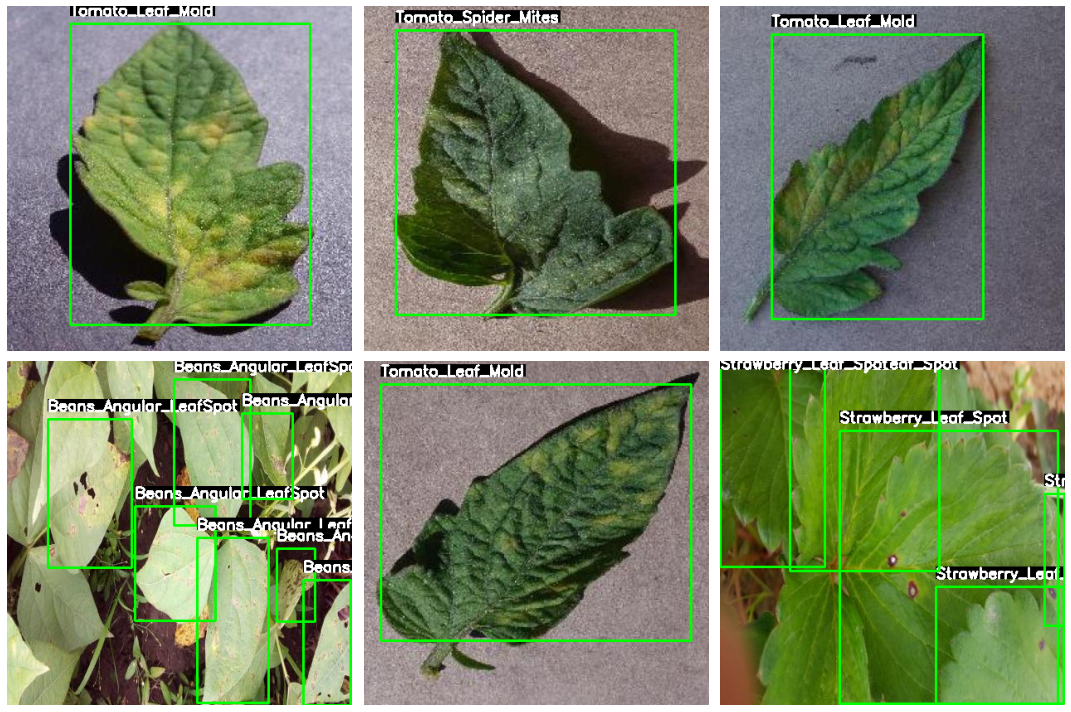

In [2]:
import yaml
random.seed(42)

# Папки с изображениями и метками
images_folder = "train/images"
labels_folder = "train/labels"

# Загрузка списка файлов изображений
image_files = os.listdir(images_folder)

# Выбор случайных изображений
random.shuffle(image_files)
random_image_files = image_files[:6]

# Отображение случайных изображений с метками
num_images = len(random_image_files)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()


with open("data.yaml", "r") as f:
    data = yaml.safe_load(f)
classes = data["names"]  # Список классов

for i in range(num_images):
    # Загрузка изображения
    image_file = os.path.join(images_folder, random_image_files[i])
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Загрузка меток из файла
    label_file = os.path.join(labels_folder, os.path.splitext(random_image_files[i])[0] + ".txt")
    if not os.path.exists(label_file):
        continue
    with open(label_file, "r") as file:
        labels = file.readlines()

    # Отображение изображения с метками
    h, w, _ = image.shape
    for label in labels:
        class_id, x_center, y_center, box_width, box_height = map(float, label.strip().split())

        # Перевод YOLO координат в координаты прямоугольника
        x1 = int((x_center - box_width / 2) * w)
        y1 = int((y_center - box_height / 2) * h)
        x2 = int((x_center + box_width / 2) * w)
        y2 = int((y_center + box_height / 2) * h)

        # Настройка уменьшенной толщины и текста
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Толщина = 1
        class_name = classes[int(class_id)] if int(class_id) < len(classes) else f"Class {int(class_id)}"

        font_scale = 0.6
        thickness = 2
        text_size = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
        text_x = x1
        text_y = y1 - 10 if y1 - 10 > 10 else y1 + 10

        # Фон под текстом (для четкости)
        cv2.rectangle(image, (text_x, text_y - text_size[1]), (text_x + text_size[0], text_y), (0, 0, 0), -1)
        cv2.putText(image, class_name, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

    # Отображение изображения
    axes[i].imshow(image)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [3]:
model = YOLO("yolov9m.pt")

100%|██████████| 39.1M/39.1M [00:01<00:00, 22.9MB/s]


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
model.train(data='data.yaml ', epochs=50, imgsz=416,
            optimizer = 'AdamW', lr0 = 1e-3, 
            project = 'YOLO9m', name='Medium_try',
            batch=32, device=device, seed=69)

Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
engine/trainer: task=detect, mode=train, model=yolov9m.pt, data=data.yaml , epochs=50, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=YOLO9m, name=Medium_try, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=69, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

train: Scanning /home/user/CourseWork/Disease/train/labels.cache... 2904 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2904/2904 [00:00<?, ?it/s]
val: Scanning /home/user/CourseWork/Disease/valid/labels.cache... 1416 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1416/1416 [00:00<?, ?it/s]


Plotting labels to YOLO9m/Medium_try/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 149 weight(decay=0.0), 156 weight(decay=0.0005), 155 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO9m/Medium_try
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.37G      1.119      2.022      1.437         89        416: 100%|██████████| 91/91 [00:24<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.25it/s]


                   all       1416       3193      0.405      0.369      0.337      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.37G      1.139      1.524      1.444         95        416: 100%|██████████| 91/91 [00:20<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.51it/s]


                   all       1416       3193      0.605      0.617      0.632      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.45G      1.113      1.371      1.422        108        416: 100%|██████████| 91/91 [00:19<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.56it/s]


                   all       1416       3193      0.515      0.428      0.406      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.37G      1.118      1.367      1.423        118        416: 100%|██████████| 91/91 [00:19<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.52it/s]


                   all       1416       3193      0.578      0.589      0.564      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.44G       1.07      1.224        1.4        123        416: 100%|██████████| 91/91 [00:19<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.59it/s]

                   all       1416       3193      0.675      0.632      0.664      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.34G      1.034      1.166      1.372         92        416: 100%|██████████| 91/91 [00:19<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.56it/s]

                   all       1416       3193      0.723      0.731      0.742       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.46G      1.007      1.106      1.361         88        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.61it/s]

                   all       1416       3193      0.692      0.672      0.716      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.37G     0.9951      1.044       1.35         94        416: 100%|██████████| 91/91 [00:19<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.61it/s]

                   all       1416       3193      0.769      0.759      0.788      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.44G     0.9654       1.01      1.335        120        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.59it/s]

                   all       1416       3193       0.75       0.76      0.796      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.48G     0.9346     0.9854      1.318         82        416: 100%|██████████| 91/91 [00:19<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.54it/s]

                   all       1416       3193      0.788      0.765      0.795      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.43G     0.9145     0.9604      1.305         84        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.64it/s]

                   all       1416       3193      0.768      0.748      0.802      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.34G     0.9029     0.9139      1.287         95        416: 100%|██████████| 91/91 [00:19<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.62it/s]

                   all       1416       3193      0.797      0.794      0.823      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.44G     0.9144     0.9002      1.295         81        416: 100%|██████████| 91/91 [00:19<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.61it/s]

                   all       1416       3193      0.792      0.756      0.795      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.37G     0.8901      0.882      1.287         99        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.61it/s]

                   all       1416       3193      0.798      0.798      0.828      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.44G     0.8826     0.8512      1.284        100        416: 100%|██████████| 91/91 [00:19<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.62it/s]

                   all       1416       3193      0.799      0.779      0.817      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.37G     0.8656     0.8375      1.265         96        416: 100%|██████████| 91/91 [00:19<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.63it/s]

                   all       1416       3193      0.819      0.795      0.827      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.44G     0.8648     0.8344      1.259         79        416: 100%|██████████| 91/91 [00:19<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.62it/s]

                   all       1416       3193      0.832      0.803      0.844      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.36G     0.8334     0.7862      1.246        112        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.64it/s]

                   all       1416       3193      0.823      0.821      0.861      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.45G     0.8274     0.7866      1.245        131        416: 100%|██████████| 91/91 [00:19<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]

                   all       1416       3193      0.797      0.807      0.837       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.37G     0.8329     0.7804      1.252        121        416: 100%|██████████| 91/91 [00:19<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.61it/s]

                   all       1416       3193      0.834      0.822       0.86      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.43G      0.821     0.7703       1.24        113        416: 100%|██████████| 91/91 [00:19<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.62it/s]

                   all       1416       3193      0.835      0.826      0.868      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.34G     0.8122     0.7441      1.224        111        416: 100%|██████████| 91/91 [00:19<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.64it/s]

                   all       1416       3193        0.8      0.812      0.847      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.43G     0.8026     0.7456      1.227         98        416: 100%|██████████| 91/91 [00:19<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]

                   all       1416       3193      0.817      0.845      0.863      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.35G     0.7947     0.7044      1.216         92        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]

                   all       1416       3193      0.833      0.825      0.862      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.42G     0.7878      0.697       1.21        138        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.64it/s]

                   all       1416       3193      0.844      0.838      0.878      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.35G     0.7625     0.6826      1.199        115        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.63it/s]

                   all       1416       3193       0.83      0.851      0.876      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.42G     0.7707     0.6707      1.196         97        416: 100%|██████████| 91/91 [00:19<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all       1416       3193       0.87      0.839      0.882      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.37G     0.7687     0.6699      1.202         92        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.60it/s]

                   all       1416       3193      0.845      0.828      0.865      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.45G       0.75     0.6582      1.186         83        416: 100%|██████████| 91/91 [00:19<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.64it/s]

                   all       1416       3193      0.874      0.844      0.887      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.35G     0.7427     0.6512      1.181        114        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.62it/s]

                   all       1416       3193      0.835      0.853      0.883       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.44G     0.7485     0.6404      1.181         90        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.61it/s]

                   all       1416       3193      0.877      0.857      0.892      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.35G     0.7399     0.6342      1.188        109        416: 100%|██████████| 91/91 [00:19<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]

                   all       1416       3193      0.853      0.864      0.888      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.44G      0.727     0.5956      1.166        102        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.61it/s]

                   all       1416       3193      0.895      0.841      0.896       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.48G     0.7249     0.5955      1.171         86        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.64it/s]

                   all       1416       3193      0.877       0.86        0.9      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.42G     0.7121     0.5781      1.159         89        416: 100%|██████████| 91/91 [00:19<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all       1416       3193      0.883      0.874      0.905      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.36G      0.707      0.581      1.151        107        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all       1416       3193      0.886      0.861      0.901      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.42G     0.7116     0.5752      1.161         96        416: 100%|██████████| 91/91 [00:19<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all       1416       3193      0.884      0.861      0.898      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.47G     0.6941     0.5624      1.144         83        416: 100%|██████████| 91/91 [00:19<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.64it/s]

                   all       1416       3193      0.887       0.86      0.905      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.44G     0.6874     0.5414       1.14        115        416: 100%|██████████| 91/91 [00:19<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]

                   all       1416       3193      0.887      0.864      0.907      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       7.3G     0.6862       0.54      1.139        107        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all       1416       3193      0.889      0.871      0.909       0.75


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.41G     0.5901     0.4369      1.083         40        416: 100%|██████████| 91/91 [00:19<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]

                   all       1416       3193      0.892      0.874      0.904       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.47G     0.5699     0.4029      1.067         53        416: 100%|██████████| 91/91 [00:19<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all       1416       3193      0.897      0.869      0.905      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.42G     0.5656     0.4011      1.059         53        416: 100%|██████████| 91/91 [00:19<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all       1416       3193       0.89       0.87      0.913      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.34G     0.5501     0.3821      1.052         50        416: 100%|██████████| 91/91 [00:19<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all       1416       3193      0.887      0.876      0.905      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       7.4G       0.54     0.3732      1.042         51        416: 100%|██████████| 91/91 [00:19<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]

                   all       1416       3193      0.906      0.874      0.913      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.33G     0.5283     0.3616      1.039         56        416: 100%|██████████| 91/91 [00:19<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.63it/s]

                   all       1416       3193      0.906      0.888      0.916      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.41G      0.524     0.3536      1.034         57        416: 100%|██████████| 91/91 [00:19<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.64it/s]

                   all       1416       3193      0.897      0.893      0.921      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.35G     0.5191     0.3505      1.027         46        416: 100%|██████████| 91/91 [00:19<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all       1416       3193      0.912      0.878      0.917      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.42G     0.5057     0.3323      1.021         52        416: 100%|██████████| 91/91 [00:19<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]

                   all       1416       3193      0.915      0.882      0.919      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.36G     0.5085     0.3358      1.026         51        416: 100%|██████████| 91/91 [00:19<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all       1416       3193      0.922      0.875      0.921      0.771



50 epochs completed in 0.387 hours.
Optimizer stripped from YOLO9m/Medium_try/weights/last.pt, 40.8MB
Optimizer stripped from YOLO9m/Medium_try/weights/best.pt, 40.8MB

Validating YOLO9m/Medium_try/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLOv9m summary (fused): 374 layers, 20,021,668 parameters, 0 gradients, 76.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.11it/s]


                   all       1416       3193      0.922      0.875      0.921      0.772
Beans_Angular_LeafSpot         83        277      0.744       0.67      0.715      0.461
            Beans_Rust         97        463      0.853      0.814      0.883      0.642
Strawberry_Angular_LeafSpot        166        193      0.936      0.911       0.96      0.803
Strawberry_Anthracnose_Fruit_Rot         47         85      0.914      0.824      0.896      0.664
Strawberry_Blossom_Blight        104        161      0.966      0.994      0.995      0.896
  Strawberry_Gray_Mold        192        200      0.956      0.915       0.95      0.687
  Strawberry_Leaf_Spot        199        779      0.946      0.833      0.936      0.866
Strawberry_Powdery_Mildew_Fruit         77        151      0.919      0.749      0.864      0.696
Strawberry_Powdery_Mildew_Leaf        155        584      0.866      0.808      0.882      0.777
         Tomato_Blight        100        100      0.985       0.99      0.9

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f5aa99547c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,  

In [6]:
df = pd.read_csv('YOLO9m/Medium_try/results.csv')

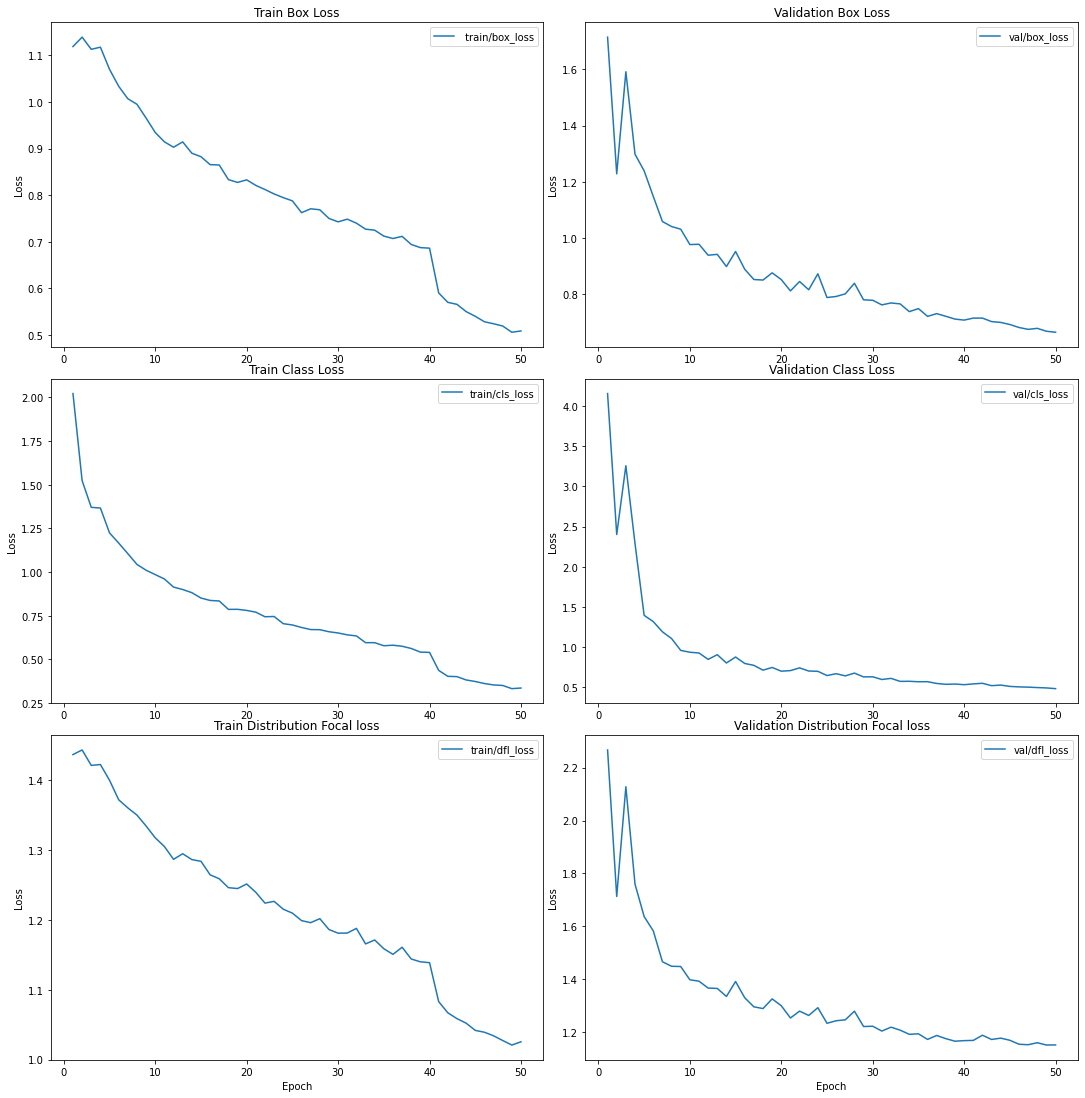

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.tight_layout()

# train/box_loss
axes[0, 0].plot(df['epoch'], df['train/box_loss'], label=' train/box_loss')
axes[0, 0].set_title('Train Box Loss')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# val/box_loss
axes[0, 1].plot(df['epoch'], df['val/box_loss'], label='val/box_loss')
axes[0, 1].set_title('Validation Box Loss')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# train/cls_loss
axes[1, 0].plot(df['epoch'], df['train/cls_loss'], label='train/cls_loss')
axes[1, 0].set_title('Train Class Loss')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# val/cls_loss
axes[1, 1].plot(df['epoch'], df['val/cls_loss'], label='val/cls_loss')
axes[1, 1].set_title('Validation Class Loss')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# train/dfl_loss
axes[2, 0].plot(df['epoch'], df['train/dfl_loss'], label='train/dfl_loss')
axes[2, 0].set_title('Train Distribution Focal loss')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].legend()

# val/dfl_loss
axes[2, 1].plot(df['epoch'], df['val/dfl_loss'], label='val/dfl_loss')
axes[2, 1].set_title('Validation Distribution Focal loss')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].legend()

plt.show()

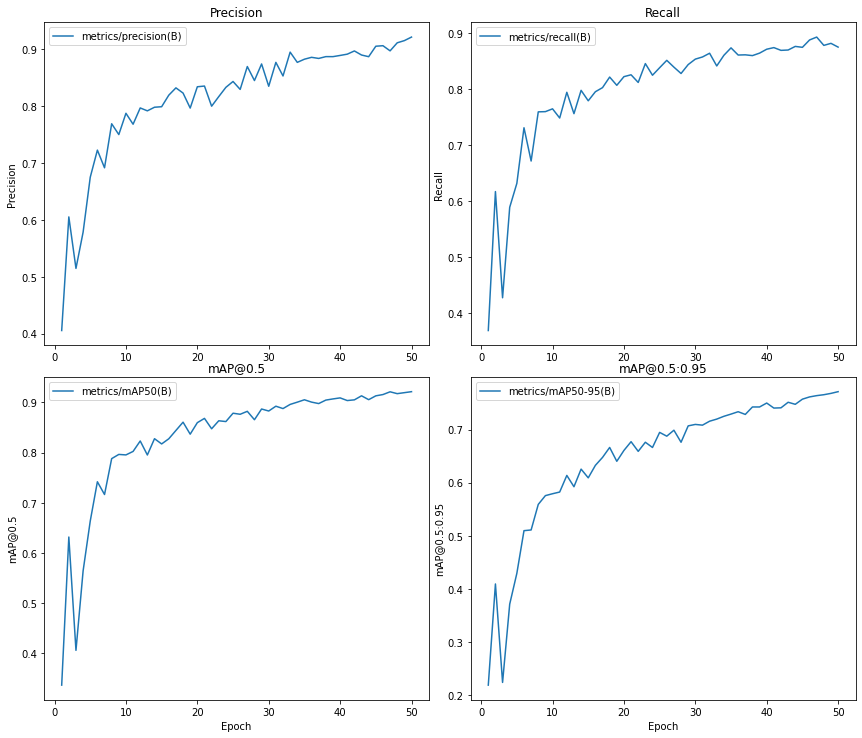

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout()

# metrics/precision(B)
axes[0, 0].plot(df['epoch'], df['metrics/precision(B)'], label='metrics/precision(B)')
axes[0, 0].set_title('Precision')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].legend()

# metrics/recall(B)
axes[0, 1].plot(df['epoch'], df['metrics/recall(B)'], label='metrics/recall(B)')
axes[0, 1].set_title('Recall')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].legend()

# График для metrics/mAP50(B)
axes[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], label='metrics/mAP50(B)')
axes[1, 0].set_title('mAP@0.5')
axes[1, 0].set_ylabel('mAP@0.5')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()

# metrics/mAP50-95(B)
axes[1, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='metrics/mAP50-95(B)')
axes[1, 1].set_title('mAP@0.5:0.95')
axes[1, 1].set_ylabel('mAP@0.5:0.95')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()

plt.show()

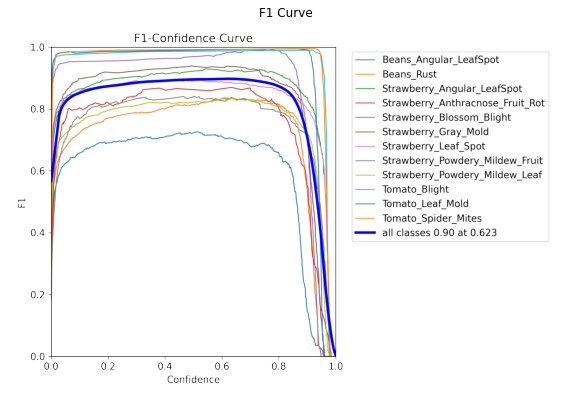

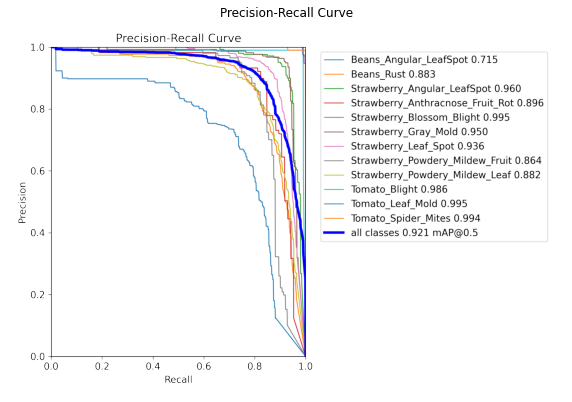

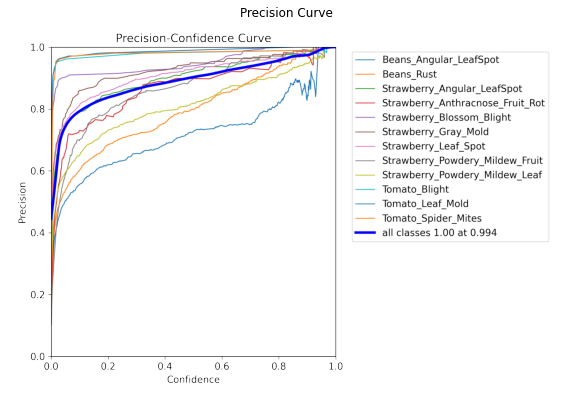

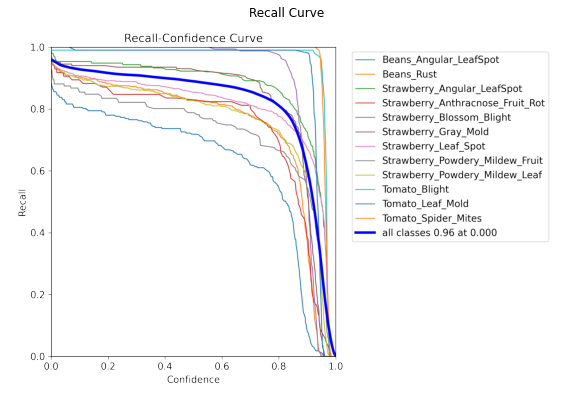

In [9]:
# F1_curve.png
f1_curve = Image.open("YOLO9m/Medium_try/F1_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(f1_curve)
plt.title("F1 Curve")
plt.axis("off")
plt.show()

# PR_curve.png
pr_curve = Image.open("YOLO9m/Medium_try/PR_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(pr_curve)
plt.title("Precision-Recall Curve")
plt.axis("off")
plt.show()

# P_curve.png
p_curve = Image.open("YOLO9m/Medium_try/P_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(p_curve)
plt.title("Precision Curve")
plt.axis("off")
plt.show()

# R_curve.png
r_curve = Image.open("YOLO9m/Medium_try/R_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(r_curve)
plt.title("Recall Curve")
plt.axis("off")
plt.show()

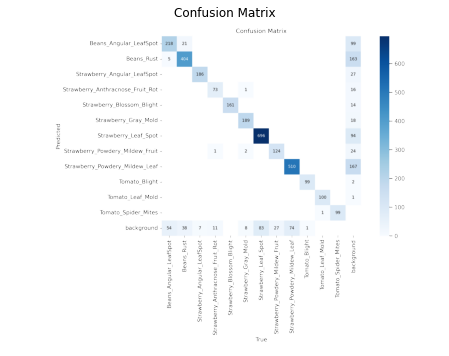

In [10]:
confusion_matrix = Image.open("YOLO9m/Medium_try/confusion_matrix.png")
plt.figure(figsize=(12, 6))
plt.imshow(confusion_matrix)
plt.title("Confusion Matrix")
plt.axis("off")
plt.show()


image 1/1 /home/user/CourseWork/Disease/test/images/1619349070358_jpg.rf.598983cd4477c6faf4dbb5dcd65f989a.jpg: 416x416 4 Beans_Angular_LeafSpots, 20.2ms
Speed: 0.8ms preprocess, 20.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)


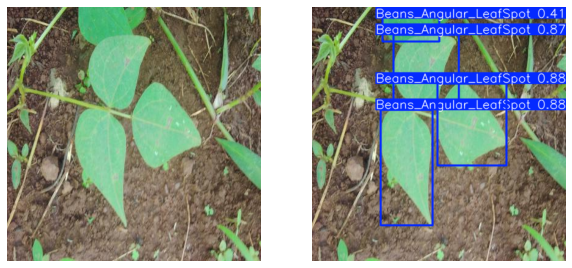

In [11]:
res = model('test/images/1619349070358_jpg.rf.598983cd4477c6faf4dbb5dcd65f989a.jpg')
detect_img = res[0].plot()
detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Отображение первого изображения
axes[0].imshow(plt.imread('test/images/1619349070358_jpg.rf.598983cd4477c6faf4dbb5dcd65f989a.jpg'))
axes[0].axis('off')

# Отображение результатов модели
axes[1].imshow(detect_img)
axes[1].axis('off')

plt.show();